# Calib sensor functions

NB study: module calib_sensor_functions.py in invisible_cities/reco

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2018-02-17 10:19:36


In [371]:
from IPython.display import Image

In [258]:
from collections import namedtuple
from enum import Enum

In [4]:
from invisible_cities.reco import calib_sensors_functions as csf

In [456]:
import invisible_cities.core.system_of_units as units
from invisible_cities.core.core_functions import timefunc
from typing import  NamedTuple

In [384]:
from invisible_cities.sierpe  import fee as FE
import scipy.signal as signal
import scipy.stats as scs

In [513]:
from numba import jit

## Types

In [632]:
class Point(NamedTuple):
    x     : float
    y     : float
        
class WfmPar(NamedTuple):
    t_tot     : int
    t_pre     : int
    t_rise_s2 : int 
    t_flat_s2 : int
    pedestal  : int
    noise     : int
    q_s2      : int

class Waveform(NamedTuple):
    t   : np.ndarray
    q   : np.ndarray

class SipmPars(NamedTuple):                
    common_threshold                 : float
    individual_thresholds            : np.ndarray
    adc_to_pes                       : np.ndarray

class SipmWaveforms(NamedTuple):
    signal_adc                       : np.ndarray
    signal_pes                       : np.ndarray
    signal_zs_individual_thresholds  : np.ndarray
    signal_zs_common_threshold       : np.ndarray

class SensorType(Enum):
    pmt   = 0
    sipm  = 1

class BlsMode(Enum):
    mean   = 0
    median = 1
    mode   = 2

## Utils

In [484]:
def array_to_row_vector(x):
    return x[np.newaxis, :]


def array_to_col_vector(x):
    return x[:, np.newaxis]
      

def line(x : float, p1 : Point, p2 : Point) ->float:
    def coef(p1, p2) ->float:
        b = (p2.y - p1.y) / (p2.x - p1.x)
        a = (p1.y * p2.x - p2.y * p1.x) / (p2.x - p1.x)
        return a, b
    a, b = coef(p1, p2)
    return a + b * x

def relative_diff_percent(x,y):
    return 100 * (x - y) / x

In [118]:
array_to_row_vector(arr).shape

(1, 4)

In [120]:
array_to_col_vector(arr).shape

(4, 1)

In [280]:
def color_generator(cx = ['b', 'k', 'r', 'y', 'g'] ):
    i=0
    while True:
        if i < len(cx):
            yield cx[i]
            i+=1
        else:
            i=0
            yield cx[i]
    

In [281]:
def plot_waveforms(wfms):
    c = color_generator()
    for wfm in wfms:
            plt.plot(wfm, next(c))
    plt.grid(True)
    plt.xlabel(r't (time units)')
    plt.ylabel(r'q (charge/energy units)')

## Waveform generator

In [313]:
def square_waveform(wp : WfmPar):
    t_s2 = 2 * wp.t_rise_s2 + wp.t_flat_s2
    t_pos = wp.t_tot - wp.t_pre - t_s2
    assert t_s2 + wp.t_pre < wp.t_tot
    
    def wf_noise(length):
        return wp.noise * np.random.randn(length)
        
    t          = np.arange(wp.t_tot)
    sgn_pre    = np.zeros(wp.t_tot)
    sgn_s2     = np.zeros(wp.t_tot)
    sgn_post   = np.zeros(wp.t_tot)
    pedestal   = np.ones(wp.t_tot) * wp.pedestal
    
    # waveform pre (before signal raises)
    f = 0
    l = wp.t_pre
    sgn_pre[f:l] = wf_noise(wp.t_pre)
    
    # signal raise
    f = l
    l = f + wp.t_rise_s2 
    p1 = Point(t[f], 0)
    p2 = Point(t[l], wp.q_s2)
    sgn_s2[f:l+1] = line(t[f:l+1], p1, p2) + wf_noise(l+1-f)
   
    # signal flattens
    f = l 
    l = f + wp.t_flat_s2
    sgn_s2[f:l] = wp.q_s2  + wf_noise(l-f)


    # signal decreases
    f = l
    l = f + wp.t_rise_s2
    p1 = Point(t[f], wp.q_s2)
    p2 = Point(t[l], 0)
    sgn_s2[f:l+1] = line(t[f:l+1], p1, p2)  + wf_noise(l+1-f)
    
    # signal post (after signal has decreases)
    f = l 
    l = wp.t_tot 
    sgn_post[f:l] = wp.noise * np.random.randn(t_pos) 
    
    return Waveform(t * units.ns, (sgn_pre + sgn_s2 + sgn_post))


def simulate_pmt_response(fee, wf):
    # Single Photoelectron class
    spe = FE.SPE()
    # FEE, with noise PMT

    # signal_i in current units
    signal_i = FE.spe_pulse_from_vector(spe, wf.q) 
    signal_fee = FE.signal_v_fee(fee, signal_i, -1) 
    wf_i_adc   = signal_i * FE.i_to_adc()
    wf_fee_adc = signal_fee * FE.v_to_adc()
    
    return Waveform(wf.t, wf_i_adc.astype(int)), Waveform(wf.t, wf_fee_adc.astype(int)) 



In [314]:
def waveform_generator(fee, wfp, sensor_type=SensorType.pmt, nsensors=5):
    """ Generate PMT-like (e.g, negative swing) and SiPM-like (positive)
        waveforms."""
    
    wfm   = np.zeros((nsensors,  wfp.t_tot), dtype=np.int)
    
    for i in range(nsensors):
        tpre         = np.random.randint(int(wfp.t_tot/3))
        wfp2        = WfmPar(t_tot     = wfp.t_tot,
                             t_pre     = tpre,
                             t_rise_s2 = wfp.t_rise_s2, 
                             t_flat_s2 = wfp.t_flat_s2,
                             noise     = wfp.noise,
                             q_s2      = wfp.q_s2,
                             pedestal  = wfp.pedestal)
        
        square_wfm   =  square_waveform(wfp2) 
        wf_i, wf_fee = simulate_pmt_response(fee, square_wfm)
        
        if sensor_type == SensorType.pmt:
            wfm [i, :] = wf_fee.q + wfp.pedestal
        elif sensor_type == SensorType.sipm:
            wfm [i, :] = wf_i.q  + wfp.pedestal
        else:
            raise TypeError(f"Unrecognized sensor type: {sensor_type}")
            
    return wfm
    

## Statistics

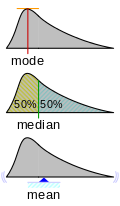

In [372]:
Image(filename='./Visualisation_mode_median_mean.svg.png') 

In [633]:
def mode(x, axis=0):
    m, c = scs.mode(x, axis=axis)
    return m

In [695]:
def amode(wfs, axis=0):
    gen_m = lambda x: np.bincount(x[x>=0]).argmax() if x[x>=0].size != 0 else -1
    return np.apply_along_axis(gen_m, axis, wfs)


In [634]:
@timefunc
def means_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mean[sensors]"""
    return np.mean(wfms, axis=1)
   

In [635]:
@timefunc
def medians_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return median[sensors]"""
    return np.median(wfms, axis=1)

In [696]:
@timefunc
def modes_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mode[sensors]"""
    return mode(wfms, axis=1)

@timefunc
def amodes_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mode[sensors]"""
    return amode(wfms, axis=1)

In [637]:
@timefunc
def maus_from_waveforms(n_MAU, wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mau[sensors]"""
    MAU   = np.full(n_MAU, 1 / n_MAU)
    mau   = signal.lfilter(MAU, 1, wfms, axis=1)
    return mau
 

## Deconvolution and waveform subtraction

In [552]:
@jit
def deconv_simple(signal, coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0] = coef * signal[0]
    for n in np.arange(1, len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r

In [568]:
@timefunc
def deconv_pmts(wfms, coef):
    return np.array([deconv_simple(wfms[i], coef) for i in range(len(wfms))])
    

In [638]:
@timefunc
def subtract_baseline(wfs, *, bls_mode=BlsMode.mean):
    if   bls_mode is BlsMode.mean:
        return wfs - array_to_col_vector(means_from_waveforms(wfs))
    elif bls_mode is BlsMode.median:
        return wfs - array_to_col_vector(medians_from_waveforms(wfs)) 
    elif bls_mode is BlsMode.mode:
        return  wfs - modes_from_waveforms(wfs) 
    else:
        raise TypeError(f"Unrecognized baseline subtraction option: {bls_mode}")
    return bls

## Waveform study

### Waveform structure:

wfms[sensor][waveform]

- Generate PMT waveforms (negative swing). 
- Generate SiPM waveforms (positive)

In [653]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
coef = fee.freq_LHPFd*np.pi

### Long waveforms

In [654]:
wfp = WfmPar(t_tot=5000,t_pre=500,t_rise_s2=20,t_flat_s2=1000,noise=1,q_s2=100, pedestal=1e+4)

In [655]:
pmt_wfms = waveform_generator(fee, wfp, sensor_type=SensorType.pmt, nsensors=5)
pm_wfms = waveform_generator(fee, wfp, sensor_type=SensorType.sipm, nsensors=5)
pmt_wfms.shape

(5, 5000)

### PMT waveforms show negative swing

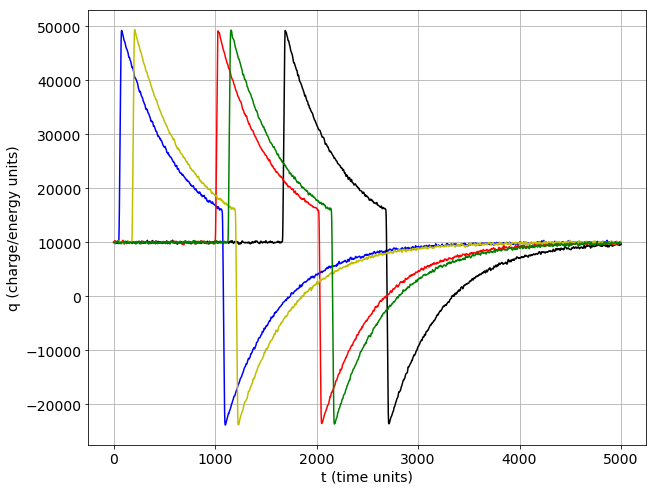

In [656]:
plot_waveforms(pmt_wfms)

### SiPM waveforms are positive

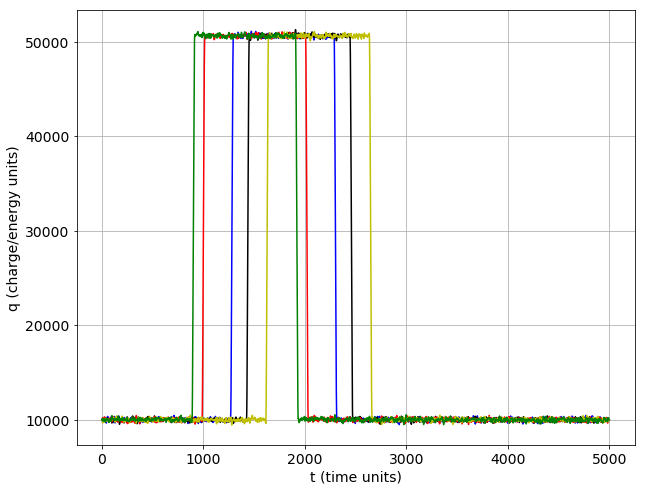

In [657]:
plot_waveforms(sipm_wfms)

## How to compute baseline for PMT and SiPMs?

- PMT waveforms (RAW) total area is zero. Thus the mean of the total waveform equals the baseline.
- SiPM waveforms are not zero total area. Thus one cannot compute the baseline **including** the signal itself, this will always yield a wrong value of the baseline.

### PMT waveforms

#### The mean of the PMT full waveform is a good estimator of the pedestal

In [658]:
relative_diff_percent(means_from_waveforms(pmt_wfms), wfp.pedestal)

Time spent in means_from_waveforms: 0.0002009868621826172 s


array([ 0.27921222,  0.68218231,  0.37705095,  0.30628303,  0.39367607])

In [659]:
means_from_waveforms(pmt_wfms)

Time spent in means_from_waveforms: 0.00020503997802734375 s


array([ 10027.9994,  10068.6868,  10037.8478,  10030.7224,  10039.5232])

#### The median is a worse  estimator of pedestal (underestimates it)

In [660]:
relative_diff_percent(medians_from_waveforms(pmt_wfms), wfp.pedestal)

Time spent in medians_from_waveforms: 0.0009469985961914062 s


array([-3.30578512, -1.52799634, -3.33247223, -3.40726953, -3.14063225])

In [661]:
medians_from_waveforms(pmt_wfms)

Time spent in medians_from_waveforms: 0.00020885467529296875 s


array([ 9680. ,  9849.5,  9677.5,  9670.5,  9695.5])

#### The mode is a good estimator but  it takes forever  to compute

In [662]:
relative_diff_percent(modes_from_waveforms(pmt_wfms), wfp.pedestal)

Time spent in modes_from_waveforms: 0.6768679618835449 s


array([[ 0.        ],
       [-0.12014417],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [663]:
modes_from_waveforms(pmt_wfms)

Time spent in modes_from_waveforms: 0.6753699779510498 s


array([[10000],
       [ 9988],
       [10000],
       [10000],
       [10000]])

#### Andrew's version of mode

In [697]:
amodes_from_waveforms(pmt_wfms)

Time spent in amodes_from_waveforms: 0.0011909008026123047 s


array([10000,  9988, 10000, 10000, 10000])

### SiPM

#### The mean is biased

In [664]:
relative_diff_percent(means_from_waveforms(sipm_wfms), wfp.pedestal)

Time spent in means_from_waveforms: 0.00020503997802734375 s


array([ 45.30172444,  45.28794745,  45.29991967,  45.30503568,  45.30984684])

In [665]:
means_from_waveforms(sipm_wfms)

Time spent in means_from_waveforms: 0.0001881122589111328 s


array([ 18282.112 ,  18277.5084,  18281.5088,  18283.2188,  18284.8272])

#### The median is a good estimator

In [666]:
relative_diff_percent(medians_from_waveforms(sipm_wfms), wfp.pedestal)

Time spent in medians_from_waveforms: 0.00031495094299316406 s


array([ 0.47770701,  0.40832586,  0.5074122 ,  0.47275442,  0.54699155])

In [667]:
medians_from_waveforms(sipm_wfms)

Time spent in medians_from_waveforms: 0.0002770423889160156 s


array([ 10048. ,  10041. ,  10051. ,  10047.5,  10055. ])

#### The mode is a unbiased estimator but it takes longer to compute

In [668]:
relative_diff_percent(modes_from_waveforms(sipm_wfms), wfp.pedestal)

Time spent in modes_from_waveforms: 0.10094594955444336 s


array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [669]:
modes_from_waveforms(sipm_wfms)

Time spent in modes_from_waveforms: 0.09955215454101562 s


array([[10000],
       [10000],
       [10000],
       [10000],
       [10000]])

#### amode (Andrew's version)

In [698]:
amodes_from_waveforms(sipm_wfms)

Time spent in amodes_from_waveforms: 0.0010533332824707031 s


array([10000, 10000, 10000, 10000, 10000])

## Baseline subtraction

### PMTs

#### The three methods work. Mean is less biased than median and much faster than mode

In [670]:
pmt_bsl_wfms = subtract_baseline(pmt_wfms, bls_mode=BlsMode.mean)

Time spent in means_from_waveforms: 0.0002048015594482422 s
Time spent in subtract_baseline: 0.0003871917724609375 s


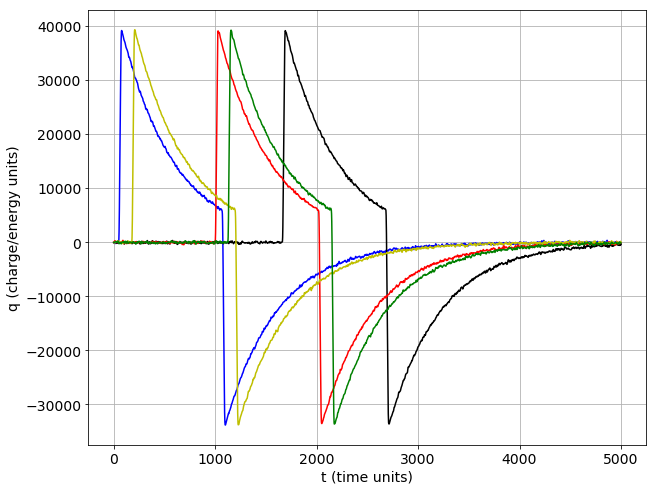

In [671]:
plot_waveforms(pmt_bsl_wfms)

In [672]:
pmt_bsl_wfms = subtract_baseline(pmt_wfms, bls_mode=BlsMode.median)

Time spent in medians_from_waveforms: 0.00023484230041503906 s
Time spent in subtract_baseline: 0.0004181861877441406 s


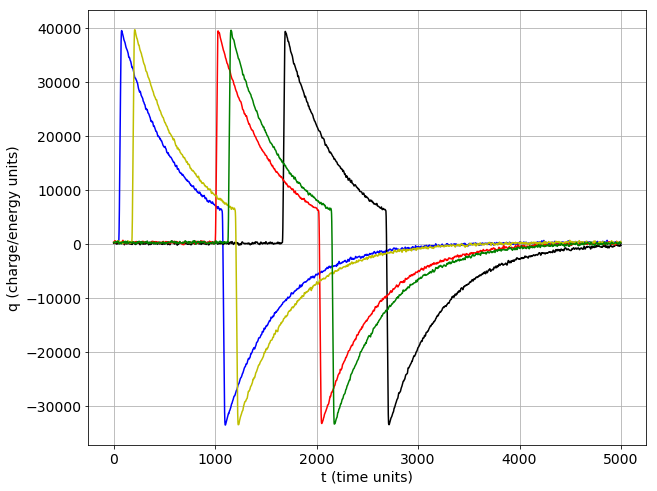

In [673]:
plot_waveforms(pmt_bsl_wfms)

In [674]:
pmt_bsl_wfms = subtract_baseline(pmt_wfms, bls_mode=BlsMode.mode)

Time spent in modes_from_waveforms: 0.6313061714172363 s
Time spent in subtract_baseline: 0.6315069198608398 s


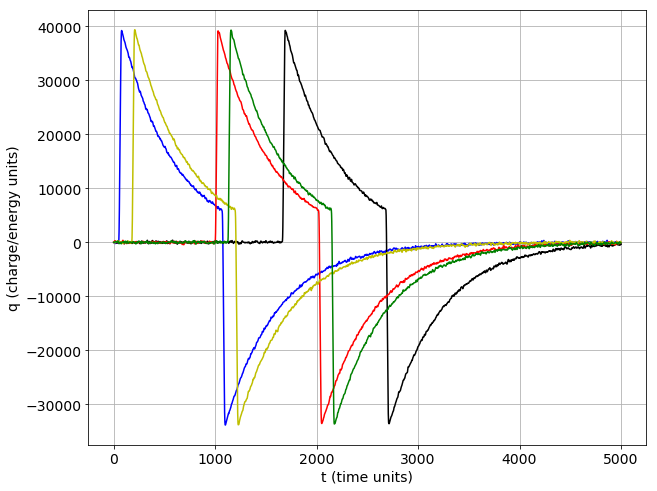

In [676]:
plot_waveforms(pmt_bsl_wfms)

### SiPMs

### The mean is biased. 

In [690]:
sipm_bsl_wfms = subtract_baseline(sipm_wfms, bls_mode=BlsMode.mean)

Time spent in means_from_waveforms: 0.0001709461212158203 s
Time spent in subtract_baseline: 0.0004978179931640625 s


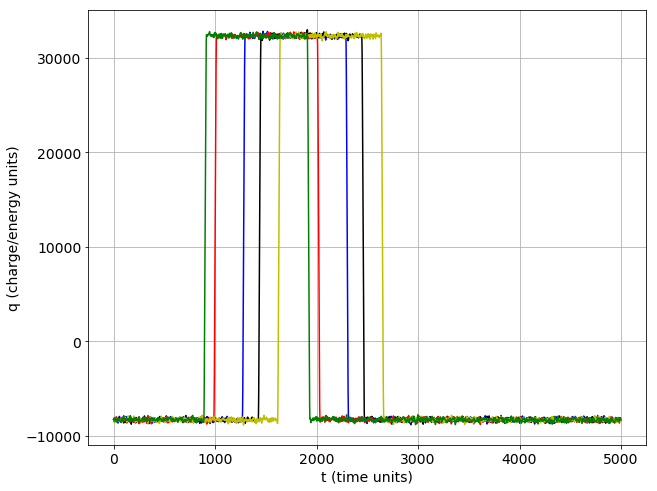

In [691]:
plot_waveforms(sipm_bsl_wfms)

#### The median is OK and fast

In [679]:
sipm_bsl_wfms = subtract_baseline(sipm_wfms, bls_mode=BlsMode.median)

Time spent in medians_from_waveforms: 0.00038123130798339844 s
Time spent in subtract_baseline: 0.0007288455963134766 s


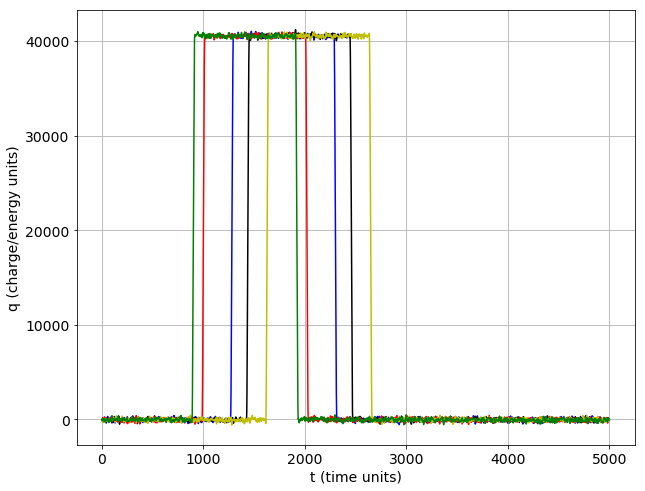

In [680]:
plot_waveforms(sipm_bsl_wfms)

#### The mode is OK bust slow

In [681]:
sipm_bsl_wfms = subtract_baseline(sipm_wfms, bls_mode=BlsMode.mode)

Time spent in modes_from_waveforms: 0.10619711875915527 s
Time spent in subtract_baseline: 0.10639810562133789 s


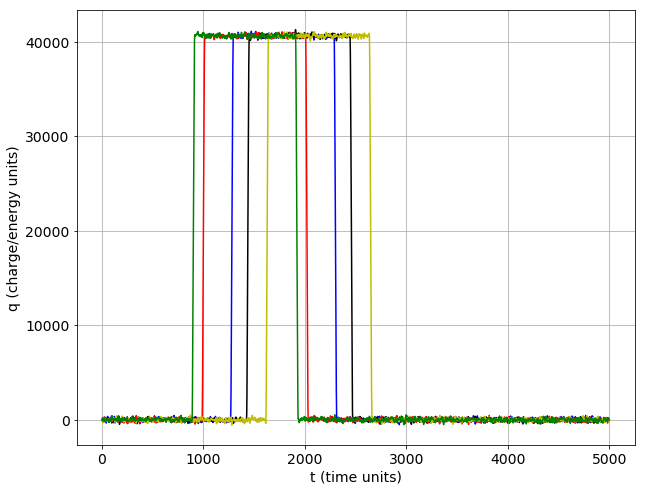

In [682]:
plot_waveforms(sipm_bsl_wfms)

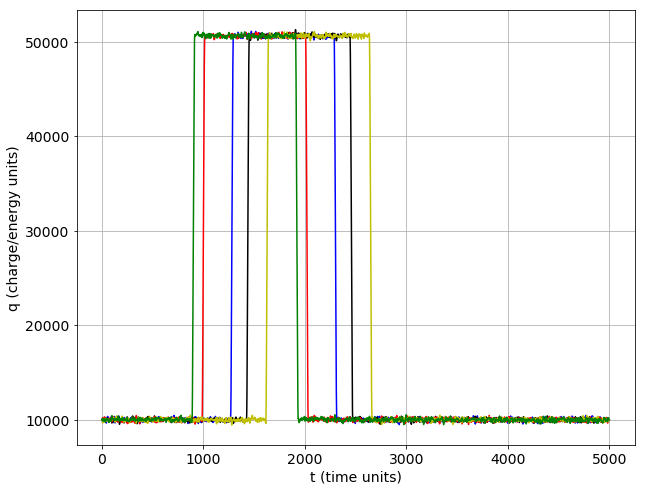

In [692]:
plot_waveforms(sipm_wfms)

In [687]:
def sipm_subtract_mode_select_signal(sipm_wfs, thr):
        zwfs = subtract_baseline(sipm_wfs, bls_mode=BlsMode.median)
        return np.where(zwfs > thr, zwf, 0)

In [693]:
sipm_bsl_wfms = sipm_subtract_mode_select_signal(sipm_wfms, thr= 3)

Time spent in medians_from_waveforms: 0.0005321502685546875 s
Time spent in subtract_baseline: 0.0008068084716796875 s


NameError: name 'zwf' is not defined